# Chapter 22: HHL  

We see systems of linear equations in many real-life applications across a wide range of areas.
For an invertible complex matrix $n \times n$ $A$ and a complex vector  $\textbf{b}$
\begin{equation}
A \cdot \textbf{x} =  \textbf{b} 
\end{equation}
we want to find $ \textbf{x}$. 

## Example

\begin{equation}
 A=
 \left( \begin{array}{cc} 
1 & - \frac{1}{3}  \\
- \frac{1}{3}  & 1\\ 
 \end{array} \right),~~~~
  \textbf{b} =
 \left( \begin{array}{c} 
1  \\
0\\ 
 \end{array} \right).
\end{equation}

with eigenvectors 

 \begin{equation}
   \textbf{u}_1=
\frac{1}{\sqrt{2}} 
\cdot
 \left( \begin{array}{c} 
1  \\
-1\\ 
 \end{array} \right),~~~~
  \textbf{u}_2=
\frac{1}{\sqrt{2}} 
\cdot
 \left( \begin{array}{c} 
1  \\
1\\ 
 \end{array} \right).
\end{equation}

and eigenvalues

\begin{equation}
\lambda_1=\frac{4}{3},~~~~\lambda_2=\frac{2}{3}.
\end{equation}

 We will use $qiskit$ command HamiltonianGate where data is a Hermitian matrix $A$ is represented and  time $t=2 \cdot \pi /8$ to perform Hamiltonian evolution and use QFT instead of inverse QFT

In [8]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from math import pi
from qiskit.quantum_info import Operator
from qiskit.extensions import HamiltonianGate

In [9]:
from qiskit.circuit.library import QFT
qft = QFT(2, inverse=False).to_gate()
qft.label = "QFT"
qft_dagger = QFT(2, inverse=True).to_gate()
qft_dagger.label = "QFT†"

In [10]:
op = Operator([[1, -1/3],[-1/3, 1]])
#op = Operator([[1, 0],[0, 1]])
# create gate which evolves according to exp(-i*op*3*pi/4)
gate = HamiltonianGate(op,3*pi/4).control()

qc = QuantumCircuit(3,2)


qc.h([0,1])

# apply gate to qubits [0, 1, 2] in circuit
qc.append(gate, [0,2])

qc.append(gate, [1,2])
qc.append(gate, [1,2])


# Do inverse QFT on counting qubits
qc.append(qft, [0,1])

# Measure counting qubits
qc.measure([0,1], [0,1])

#01 10
#qc.decompose().decompose().decompose().draw(fold=120)

qc.draw(fold=120)

┌───┐                                             ┌──────┐┌─┐   
q_0: ┤ H ├───────■─────────────────────────────────────┤0     ├┤M├───
     ├───┤       │                                     │  QFT │└╥┘┌─┐
q_1: ┤ H ├───────┼──────────────■──────────────■───────┤1     ├─╫─┤M├
     └───┘┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐└──────┘ ║ └╥┘
q_2: ─────┤ Hamiltonian ├┤ Hamiltonian ├┤ Hamiltonian ├─────────╫──╫─
          └─────────────┘└─────────────┘└─────────────┘         ║  ║ 
c: 2/═══════════════════════════════════════════════════════════╩══╩═
                                                                0  1

Circuit estimating $U_t$ by Hamiltonian simulation with accuracy of two qubits. 
The circuit is composed of $3$ qubits, qubits $0$, $1$, represent the control register and qubit $2$ represents   $b=|0 \rangle$.
To estimate the phase $\theta$ we perform  QFT  to the $2$ control qubits.



Total count are: {'01': 5025, '10': 4975}


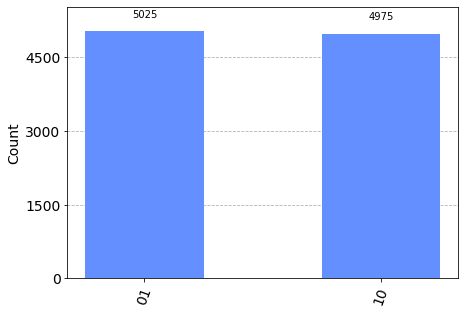

In [11]:
simulator = Aer.get_backend('qasm_simulator')
result=execute(qc,simulator,shots=10000).result()
counts = result.get_counts()
print("\nTotal count are:",counts)

plot_histogram(counts)

The measured values correspond to the binary values $10$ and $01$.

In [12]:
op = Operator([[1, -1/3],[-1/3, 1]])
#op = Operator([[1, 0],[0, 1]])
# create gate which evolves according to exp(-i*op*3*pi/4)
gate = HamiltonianGate(op,3*pi/4).control()

gate_daggar = HamiltonianGate(op,3*pi/4).inverse().control()

## Conditioned  Rotation and Un-computation

 We perform conditioned  rotation on the auxiliary state $|0 \rangle$ with measured two control qubits being $|10 \rangle$ representing $\tilde \lambda_1=2$ and $|01  \rangle$ representing $\tilde \lambda_2=1$, using a conditional $RY$ gate controlled by $\tilde \lambda$ represented by qubits $1$ and $2$, then we un-compute. The result is represented in the qubit $3$ in the case the qubit $0$ is one

In [13]:
qc = QuantumCircuit(4)
qc.h([1,2])

# apply gate to qubits [0, 1, 2] in circuit
qc.append(gate, [1,3])

qc.append(gate, [2,3])
qc.append(gate, [2,3])

# Do QFT on counting qubits
qc.append(qft, [1,2])

#rotate
#10
qc.cry(pi/3,2,0)
#01
qc.cry(pi,1,0)
#un-computing
qc.append(qft_dagger, [1,2])

qc.append(gate_daggar, [2,3])
qc.append(gate_daggar, [2,3])

qc.append(gate_daggar, [1,3])

qc.h([1,2])

qc.draw(fold=180)

┌─────────┐┌───────┐                                                           
q_0: ──────────────────────────────────────────────────────────┤ Ry(π/3) ├┤ Ry(π) ├───────────────────────────────────────────────────────────
     ┌───┐                                             ┌──────┐└────┬────┘└───┬───┘┌───────┐                                             ┌───┐
q_1: ┤ H ├───────■─────────────────────────────────────┤0     ├─────┼─────────■────┤0      ├─────────────────────────────────────■───────┤ H ├
     ├───┤       │                                     │  QFT │     │              │  QFT† │                                     │       ├───┤
q_2: ┤ H ├───────┼──────────────■──────────────■───────┤1     ├─────■──────────────┤1      ├───────■──────────────■──────────────┼───────┤ H ├
     └───┘┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐└──────┘                    └───────┘┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐└───┘
q_3: ─────┤ Hamiltonian ├┤ Hamiltonian ├┤ Hamiltonian ├─────────────────────────────────────┤ Hamiltonian ├┤ Hamiltonian ├┤ Hamiltonian ├─────
          └─────────────┘└─────────────┘└─────────────┘                                     └─────────────┘└─────────────┘└─────────────┘

The $HHL$ circuit, we perform conditioned  rotation on the auxiliary state $|0 \rangle$ using a  $RY$ gate controlled by $\tilde \lambda$ represented by qubits $1$ and $2$, then we un-compute

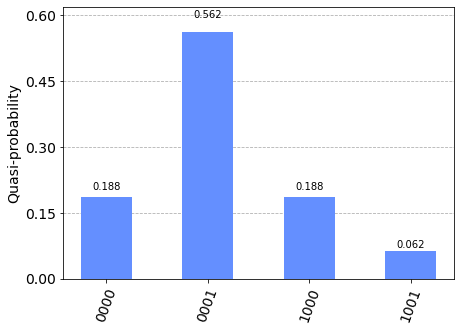

In [14]:
simulator = Aer.get_backend('statevector_simulator')
# Run and get counts
result=execute(qc,simulator).result()
counts = result.get_counts()
plot_histogram(counts)

The measured result of our small $HHL$ simulation   is represented in the qubit $3$ in the if the qubit $0$ is one, with the probability values $0.562$ and $0.0622$.

The measured result of our small $HHL$ simulation is  is represented in the qubit $3$ in the case the qubit $0$ is one 

\begin{equation}
 \textbf{x}^2_m=\left( \begin{array}{c} 
\frac{0.56}{0.562 + 0.0622} \\
\frac{0.0622}{0.562 + 0.062}\\ 
 \end{array} \right).
\end{equation}

with the measured value being

\begin{equation}
 \textbf{x}_m=\left( \begin{array}{c} 
0.948869  \\
0.31567\\ 
 \end{array} \right)
 \approx 
 \textbf{x}_n=\left( \begin{array}{c} 
0.948683  \\
0.316228\\ 
 \end{array} \right).
\end{equation}
